Authors:
Goto, Ipei B.
Quinto, Christopher A.
Talato, Joshua P.

Acronyms : 
- THI = Total Household Income

Objective: 
1. Explore the data set.
    - See which attributes are continuous / categorial.
        - Visually represent them.
    - Identify which attributes of a household has a relationship with THI.
        - Correctly identify if attributes that has correlations with THI are solely region based or nationwide.

3. Visualize the relationship in a graphical manner

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import zscore

In [2]:
df = pd.read_csv("Family Income and Expenditure.csv")

Measuring the data

- There are 41,544 rows. with 60 columns!

In [3]:
df.shape

(41544, 60)

Data types Categorical or Continous


In [4]:
print(df.dtypes)

Total Household Income                            int64
Region                                           object
Total Food Expenditure                            int64
Main Source of Income                            object
Agricultural Household indicator                  int64
Bread and Cereals Expenditure                     int64
Total Rice Expenditure                            int64
Meat Expenditure                                  int64
Total Fish and  marine products Expenditure       int64
Fruit Expenditure                                 int64
Vegetables Expenditure                            int64
Restaurant and hotels Expenditure                 int64
Alcoholic Beverages Expenditure                   int64
Tobacco Expenditure                               int64
Clothing, Footwear and Other Wear Expenditure     int64
Housing and water Expenditure                     int64
Imputed House Rental Value                        int64
Medical Care Expenditure                        

Now let's remove outliers.  
remove all rows that have outliers in at least one column.

Outliers ALWAYS MESS UP THE TRAINING OF THE MODEL. Therefore, it is imperative that we remove such outliers

>( < 3).all(axis=1) checks if, for each row, all column values are within 3 standard deviations from the mean   
>Removes approximately 0.3% of data points

Only pick the int64, i.e the continous variable types.

Create a correlation matrix.

See which ones correlate the most with Total Household Icome

> note that this is for all regions of the Philippines. this is going to be a one size fits all approach.

#### Geographic Data can Imply autocorrelation   
> This means nearby locations tend to have more similar characteristics, which violates traditional regression assumptions.   
#### Picking the right model   
> It means that we have to pick a model that addresses this. So we have to use Spatial Regression Models.


In [ ]:
philippine_regions = {
    'NCR': (14.5995, 120.9842),  # Manila
    'CAR': (16.4023, 120.5960),  # Baguio City
    'Region I': (16.6499, 120.3352),  # San Fernando, La Union
    'Region II': (16.6799, 121.7700),  # Tuguegarao City
    'Region III': (15.1349, 120.5698),  # City of San Fernando, Pampanga
    'Region IV-A': (14.3189, 121.1863),  # Calamba, Laguna
    'MIMAROPA': (13.1681, 121.2461),  # Calapan City, Oriental Mindoro
    'Region V': (13.6380, 123.1854),  # Legazpi City
    'Region VI': (10.7200, 122.5621),  # Iloilo City
    'Region VII': (10.3482, 123.8902),  # Cebu City
    'Region VIII': (11.2448, 125.0064),  # Tacloban City
    'Region IX': (8.9500, 125.0667),  # Zamboanga City
    'Region X': (8.4542, 124.6319),  # Cagayan de Oro City
    'Region XI': (7.0664, 125.5928),  # Davao City
    'Region XII': (6.9175, 125.1491),  # Koronadal City
    'Region XIII': (9.3054, 126.0379),  # Surigao City
    'BARMM': (7.8624, 124.4452)  # Cotabato City
}

# Add coordinates to your dataframe
df['latitude'] = df['Region'].map(
    lambda x: philippine_regions.get(x, (0, 0))[0])
df['longitude'] = df['Region'].map(lambda x: philippine_regions.get(x, (0, 0))[1])

### Justification for using Cities.  
1. Consistent representation
2. Administrative significance
3. Captures regional centrality
4. Enables spatial analysis techniques

Now, to justify why we removed the columns shown below,  
It is because we are currently only looking to develop a model based on expenditure types.

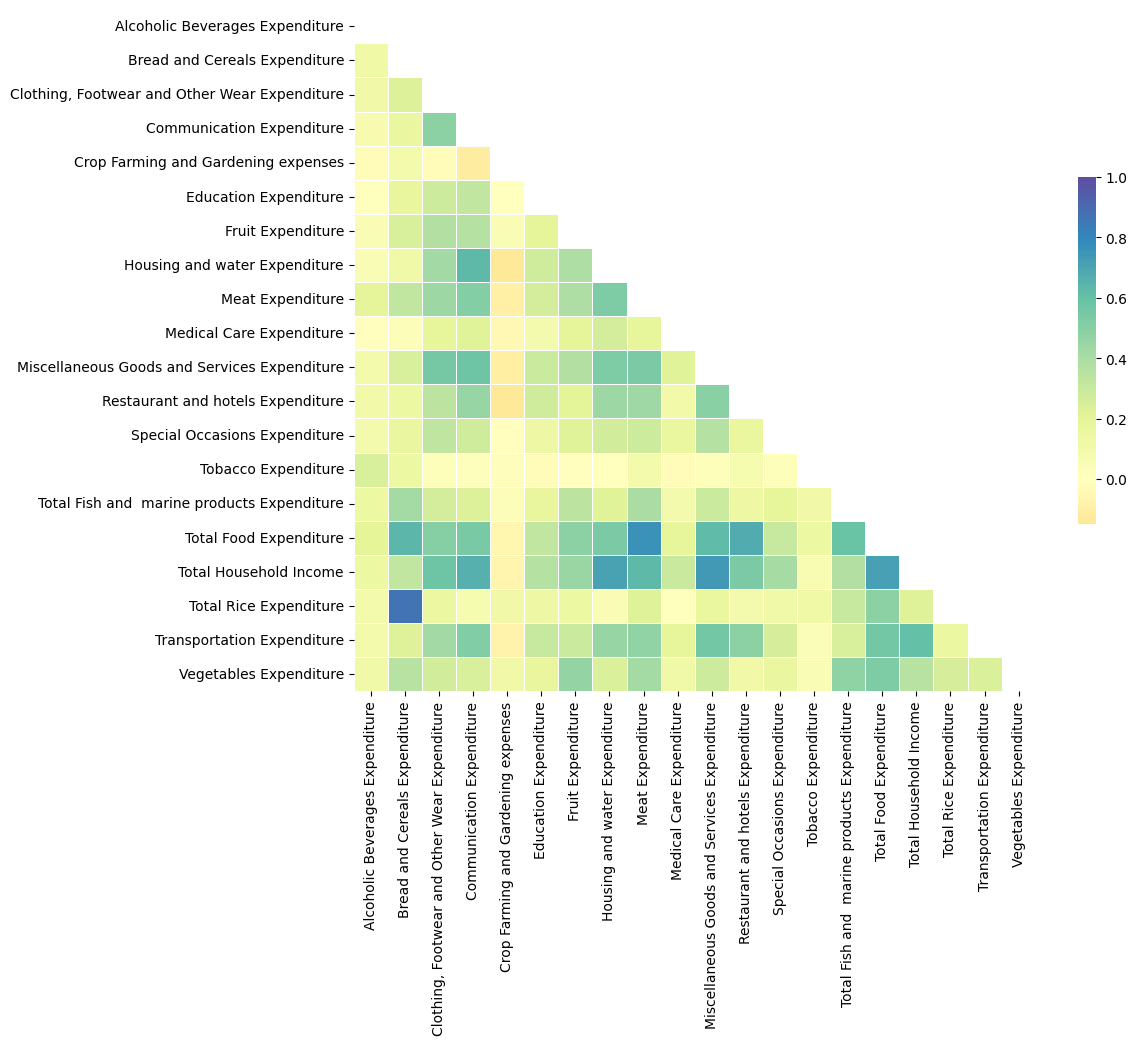

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# List of columns to drop
dropped_columns = [
    'Total Number of Family members',
    'Members with age less than 5 year old',
    'Members with age 5 - 17 years old',
    'Total number of family members employed',
    'House Floor Area',
    'House Age',
    'Number of bedrooms',
    'Electricity',
    'Number of Television',
    'Number of CD/VCD/DVD',
    'Number of Component/Stereo set',
    'Number of Refrigerator/Freezer',
    'Number of Washing Machine',
    'Number of Airconditioner',
    'Number of Car, Jeep, Van',
    'Number of Landline/wireless telephones',
    'Number of Cellular phone',
    'Number of Personal Computer',
    'Number of Stove with Oven/Gas Range',
    'Number of Motorized Banca',
    'Number of Motorcycle/Tricycle',
    'Household Head Age',
    'Agricultural Household indicator',
    'Imputed House Rental Value',
    'Total Income from Entrepreneurial Acitivites',
    'Main Source of Income',
    'Household Head Sex',
    'Household Head Marital Status',
    'Household Head Highest Grade Completed',
    'Household Head Job or Business Indicator',
    'Household Head Occupation',
    'Household Head Class of Worker',
    'Type of Household',
    'Type of Building/House',
    'Type of Roof',
    'Type of Walls',
    'Tenure Status',
    'Toilet Facilities',
    'Main Source of Water Supply'
]

# Separate the 'Region', 'Longitude', and 'Latitude' columns
region_column = df['Region']
longitude_column = df['longitude']
latitude_column = df['latitude']

# Drop the specified columns to keep only continuous numerical columns
continous_df = df.drop(columns=dropped_columns, axis=1)

# Retain the 'Region', 'Longitude', and 'Latitude' columns in the dataframe
continous_df['Region'] = region_column
continous_df['longitude'] = longitude_column
continous_df['latitude'] = latitude_column

# Remove outliers only from the numerical columns, excluding 'Longitude' and 'Latitude'
# Compute z-scores for only numeric columns but exclude 'Longitude' and 'Latitude'
numeric_columns = continous_df.select_dtypes(include=[np.number]).columns
numeric_columns_to_filter = numeric_columns.difference(
    ['longitude', 'latitude'])

continous_df_no_outliers = continous_df[
    (np.abs(zscore(continous_df[numeric_columns_to_filter])) < 3).all(axis=1)
]

# Compute correlation matrix for numerical columns, excluding 'Longitude' and 'Latitude'
corr = continous_df_no_outliers[numeric_columns_to_filter].corr()

# Create a mask for the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="Spectral", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Printing out the specific values

In [7]:
print(corr['Total Household Income'].sort_values(ascending=False))

Total Household Income                           1.000000
Miscellaneous Goods and Services Expenditure     0.735363
Total Food Expenditure                           0.716781
Housing and water Expenditure                    0.699895
Communication Expenditure                        0.662963
Meat Expenditure                                 0.630590
Transportation Expenditure                       0.605024
Clothing, Footwear and Other Wear Expenditure    0.577841
Restaurant and hotels Expenditure                0.533553
Fruit Expenditure                                0.447552
Special Occasions Expenditure                    0.410937
Total Fish and  marine products Expenditure      0.374377
Education Expenditure                            0.367018
Vegetables Expenditure                           0.358815
Bread and Cereals Expenditure                    0.320619
Medical Care Expenditure                         0.299789
Total Rice Expenditure                           0.222858
Alcoholic Beve

#### From highest to lowest, the expenditures that have a significant correlation with Total Household Income are:
1. Miscellaneous Goods and Services Expenditure     0.735363
2. Total Food Expenditure                           0.716781
3. Housing and water Expenditure                    0.699895
4. Communication Expenditure                        0.662963
5. Meat Expenditure                                 0.630590
6. Transportation Expenditure                       0.605024
7. Clothing, Footwear and Other Wear Expenditure    0.577841
8. Restaurant and hotels Expenditure                0.533553

#### Low Education Expenditure Correlation
>  A surprising observation is that Education doesn't have a strong correlation (a value equal greater than 0.5) to Total Household Income.
#### Meaning that Education expenses isn't an indicator for total household income for the Philippines as a whole 
> Why is that?  
>> Possible reasons  
>> 1. Public Education Systems reduces out of pocket expenses  
>> 2. Education is not as important as other type of expenses, so it gets left behind.  
>>> - Let's see if this holds true if we look at the regions individually.


